Geospatial vector data is a way of representing geographic features in a digital format using points, lines, and polygons. Unlike raster data, which represents geographic data as a grid of cells or pixels, vector data represents features more precisely with distinct shapes and boundaries. Each vector feature can have associated attributes, such as names, types, or other descriptive information.

### Types of Geospatial Vector Data

- **Points**: Represent discrete locations such as cities, landmarks, or individual trees. Each point has a specific location defined by coordinates (e.g., latitude and longitude).

- **Lines** (or polylines): Represent linear features such as roads, rivers, or boundaries. Lines are composed of a series of connected points. 

- **Polygons** (or multipolygons): Represent areas or shapes such as lakes, parks, or country borders. Polygons are defined by a series of points that create a closed shape.  

Shapefiles are one of the most common formats for vector data. They store points, lines, and polygons along with attribute information. The US Census Bureau makes a number of shapefiles available [here](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html). In this notebook, we'll walkthrough how to load shapefiles into GeoPandas, plotting the boundaries and create a choropleth map based on a second dataset (choropleth maps are those where the color of each shape is based on the value of an associated variable).

To start, download US state shapefile *cb_2018_us_state_500k.zip* from the [United States Census Bureau boundary files page](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html). Under the *State* subheader, you will see three files:

- *cb_2018_us_state_500k.zip*
- *cb_2018_us_state_5m.zip*
- *cb_2018_us_state_20m.zip*

The 500k files are the most detailed, but also the largest. The 20m files are the smallest, but at the cost of some dramatic simplification. The 5m files fall somewhere between the other two. We will work with the 500k files. 

Once downloaded, the shapefile can be loaded into a GeoPandas DataFrame as follows:

In [2]:

import numpy as np
import pandas as pd
import geopandas as gpd

shp_path = "cb_2018_us_state_500k.zip"

dfshp = gpd.read_file(shp_path)

dfshp.head(5)


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."



<br>

The geometry column is a special column in a GeoDataFrame that stores the geometric shapes associated with each row (in this case, the shapes in latitude-longitude pairs that define the boundary of each state). This column contains the vector data that defines the spatial features in the dataset. Some states have boundaries defined by a MULTIPOLYGON, such as Hawaii, whose boundary consists of multiple closed POLYGONS. If it isn't already present, the geometry column needs to be defined. 

We can plot the data present in the present in the shapefile by calling the GeoDataFrame's `plot` method:

<Axes: >

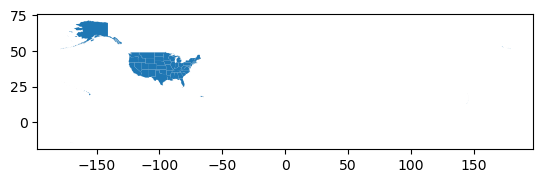

In [3]:

dfshp.plot()


<br>

Let's zoom in and focus on a map of the lower 48 states only:

<Axes: >

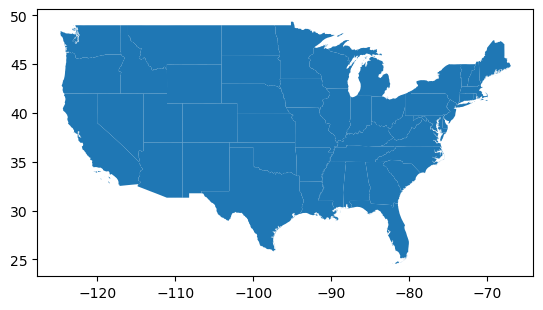

In [10]:

exclude = ["American Samoa", "Alaska", "Hawaii", "Guam", "United States Virgin Islands",
           "Commonwealth of the Northern Mariana Islands", "Puerto Rico"]

dfshp48 = dfshp[~dfshp.NAME.isin(exclude)].reset_index(drop=True)

dfshp48.plot()



<br>

We can get a better view of the boundaries of each state by calling `boundary.plot`:

<Axes: >

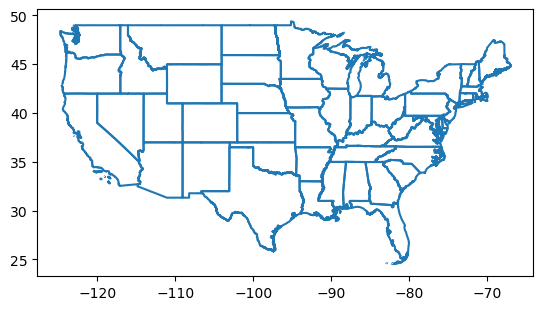

In [11]:

dfshp48.boundary.plot()



By default, the plots rendered via GeoPandas are smaller than we might like. We can increase the size of the rendered map, suppress ticklabels, change the boundary color and add a title as follows:


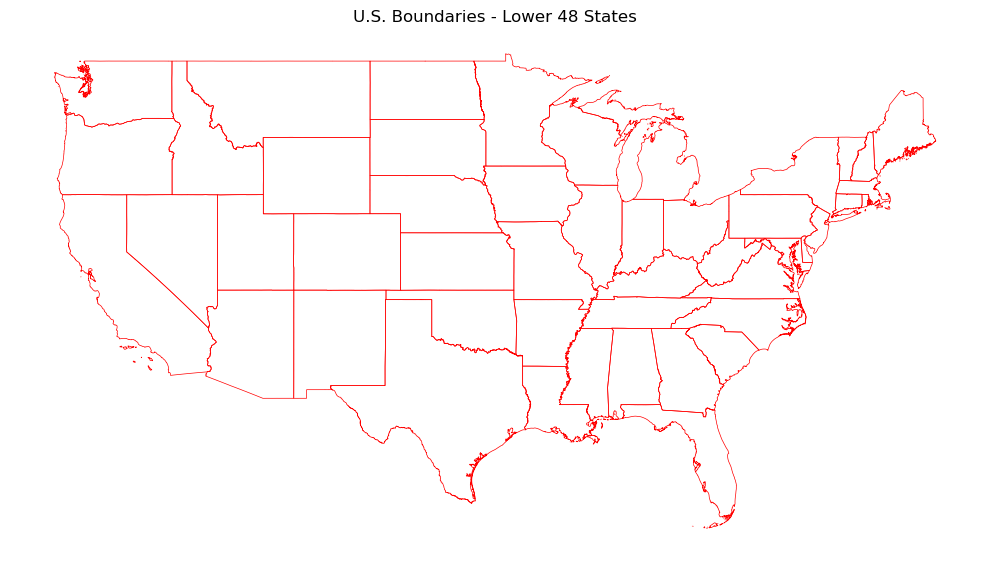

In [32]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)

ax.set_title("U.S. Boundaries - Lower 48 States")
dfshp48.boundary.plot(ax=ax, edgecolor="red", linewidth=.50)

ax.axis("off")

plt.show()



<br>

To overlay the state name at the center of each state, use:

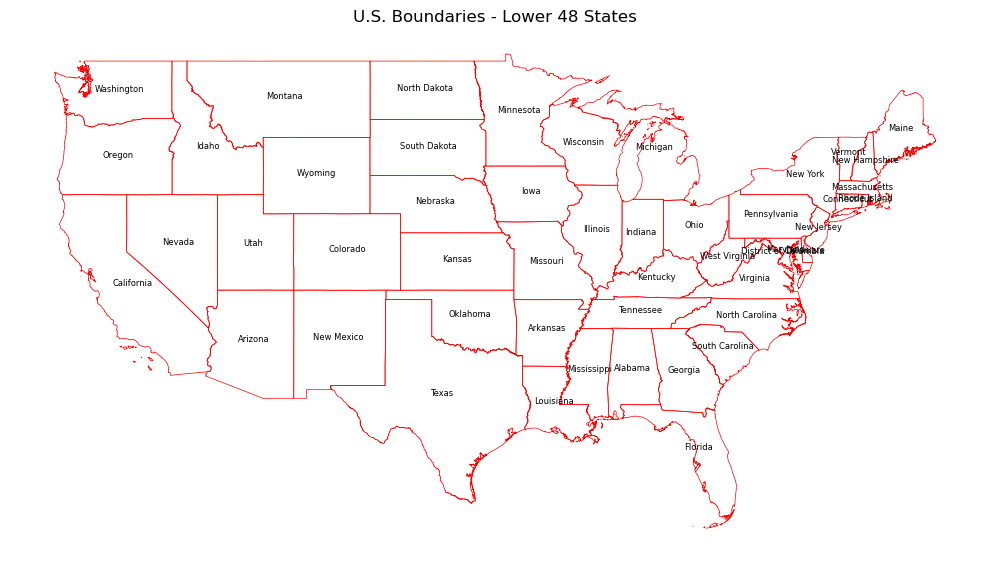

In [34]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
ax.set_title("U.S. Boundaries - Lower 48 States")
dfshp48.boundary.plot(ax=ax, edgecolor="red", linewidth=.50)
dfshp48.apply(lambda x: ax.annotate(x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), axis=1)
ax.axis("off")
plt.show()



<br>

In the shapefile, ALAND and AWATER represent the land and water area of each state in square meters. To create a choropleth map based on the natural log of AWATER, include the `column` argument to the `plot` method:

<Axes: >

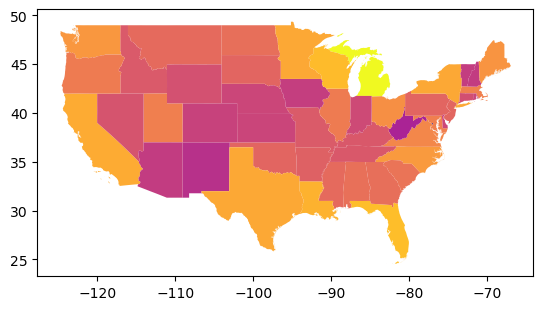

In [42]:

# Compute natural log of AWATER to get better separation by state.
dfshp48["log_AWATER"] = np.log(dfshp48["AWATER"])
dfshp48.plot(column="log_AWATER", cmap="plasma")


<br>

We can reformat the map as before, while also adding a legend to give context the difference in colors by state. Options for colormaps are available [here](https://matplotlib.org/stable/users/explain/colors/colormaps.html):


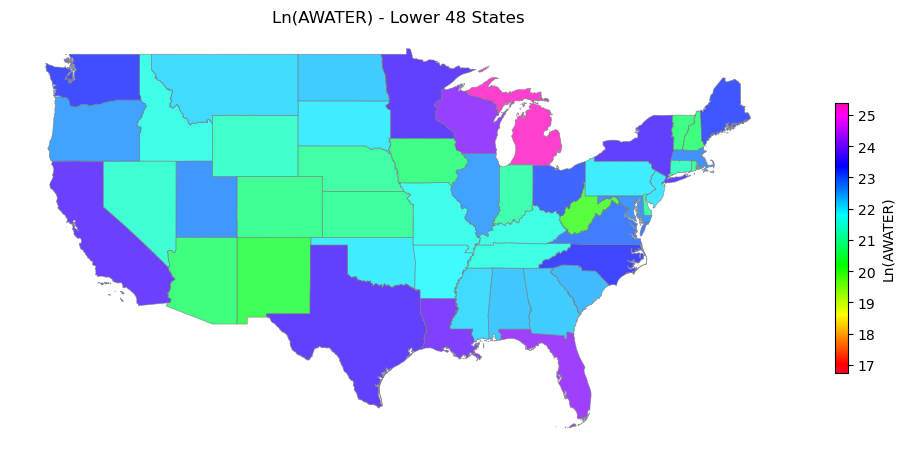

In [60]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
ax.set_title("Ln(AWATER) - Lower 48 States")
dfshp48.plot(
    ax=ax, column="log_AWATER", edgecolor="gray", linewidth=.50, 
    cmap="gist_rainbow", alpha=.750, legend=True,
    legend_kwds={"label": "Ln(AWATER)", "orientation": "vertical", "shrink": .35}
    )
ax.axis("off")
plt.show()



### Congressional District Shapefiles

For variety, let's download the Congressional District shapefile and plot the boundaries. It is available at the same link as above, and is identified as *cb_2018_us_cd116_500k.zip*. Reading the file into GeoPandas and displaying the first 5 rows yields:

In [62]:

dfc = gpd.read_file("cb_2018_us_cd116_500k.zip")

print(f"dfc.shape: {dfc.shape}")

dfc.head(5)


dfc.shape: (441, 9)


,STATEFP,CD116FP,AFFGEOID,GEOID,LSAD,CDSESSN,ALAND,AWATER,geometry
0,17,10,5001600US1710,1710,C2,116,777404163,31605644,"POLYGON ((-88.19882 42.41557, -88.19860 42.415..."
1,47,06,5001600US4706,4706,C2,116,16770155959,324676580,"POLYGON ((-87.15023 36.56770, -87.14962 36.568..."
2,48,06,5001600US4806,4806,C2,116,5564805243,255530191,"POLYGON ((-97.38860 32.61731, -97.38856 32.618..."
3,48,07,5001600US4807,4807,C2,116,419784487,3069802,"POLYGON ((-95.77383 29.87515, -95.76962 29.875..."
4,48,26,5001600US4826,4826,C2,116,2349987793,191353567,"POLYGON ((-97.39826 32.99996, -97.39792 33.013..."



We again display the boundaries:

<Axes: >

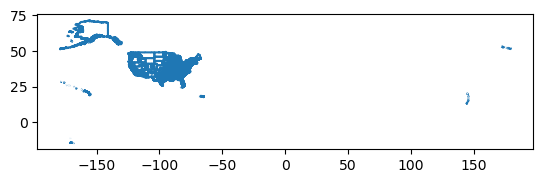

In [66]:

dfc.boundary.plot()


We'd like to focus on the lower 48 states again, but this time the shapefile doesn't have a NAME column. How should we proceed?

One approach is to define a bounding box that encloses the lower 48 states, then filter the shapefile to retain only those congressional districts whose geometry intersects the bounding box. GeoPandas provides coordinate based indexing with the `cx` indexer, which slices using a bounding box. Geometries in the GeoSeries or GeoDataFrame that intersect the bounding box will be returned.

For the lower 48 states bounding box, we'll use **(-125, 24.6), (-65, 50)**, southwest to northeast. We also include a circle marker at the center of each congressional district:


C:\Users\jtriv\AppData\Local\Temp\ipykernel_8996\3296541533.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dfc48.geometry.centroid.plot(ax=ax, markersize=6, color="red")


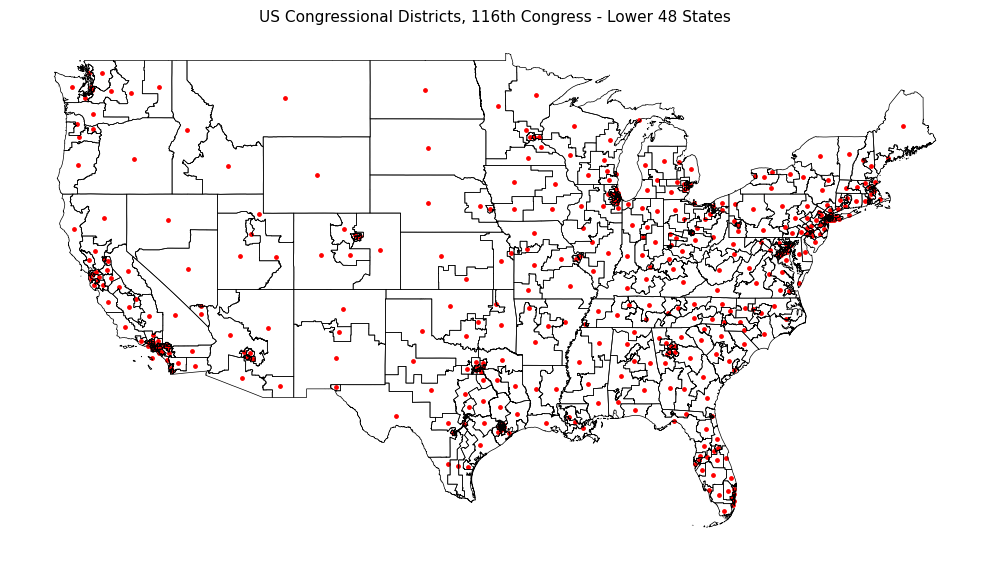

In [80]:

xmin, ymin, xmax, ymax = -125, 24.6, -65, 50
dfc48 = dfc.cx[xmin:xmax, ymin:ymax]



fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
ax.set_title("US Congressional Districts, 116th Congress - Lower 48 States", fontsize=11)
dfc48.boundary.plot(ax=ax, edgecolor="black", linewidth=.50)
dfc48.geometry.centroid.plot(ax=ax, markersize=6, color="red")
ax.axis("off")
plt.show()



<br>

### GeoJSON

Working with GeoJSON is much the same as working with shapefiles, one difference being that with GeoJSON, vector data is contained within a single file as opposed to an archive of multiple file types. See [here](https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json) for an example.

But once read into GeoPandas, we work with it the same way. We can load US state boundary files as GeoJSON from GitHub via:

In [81]:

dfstate = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")

dfstate.head()


,id,name,density,geometry
0,01,Alabama,94.650,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
1,02,Alaska,1.264,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691..."
2,04,Arizona,57.050,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
3,05,Arkansas,56.430,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,06,California,241.700,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."


<Axes: >

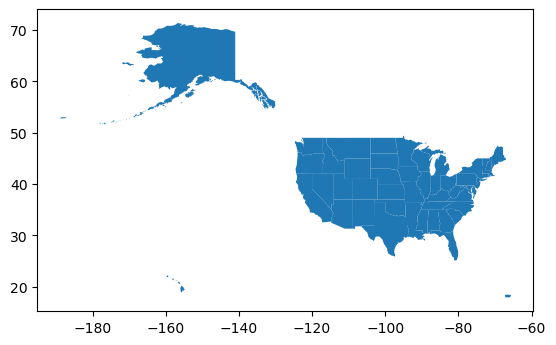

In [82]:

dfstate.plot()